In [1]:
import matplotlib.pyplot as plt
import os,glob
import numpy as np
import seaborn as sns
from scipy.special import kn,zetac
import copy
import mypyslha as pyslha
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def getContour(xpts,ypts,zpts,levels):
    """
    Uses pyplot tricontour method to obtain contour
    curves in a 2D plane.

    :return: A dictionary with a list of contours for each level
    """
    
    fig = plt.figure()
    x = copy.deepcopy(xpts)
    y = copy.deepcopy(ypts)
    z = copy.deepcopy(zpts)
    CS = plt.tricontour(x,y,z,levels=levels)    
    levelPts = {}
    for il,level in enumerate(CS.levels):
        levelPts[level] = []
        c = CS.collections[il]        
        paths = c.get_paths()
        for path in paths:
            levelPts[level].append(path.vertices)
    plt.close(fig)
    
    return levelPts

## Get SModelS Output and Cross-sections

In [3]:
rValues = []
allAna = []
bestAna = []
rValuesByAna = {}
lambdaL = []
lambdaR = []
mLQ = []

kfactor = 1.5

for fname in glob.glob('../data/smodels_BS2p/*.py'):
    slhafile = os.path.basename(fname).replace('.py','')
    slhadata = pyslha.readSLHAFile(os.path.join('../data/slha_BS2p/',slhafile))
    with open(fname,'r') as f:
        smodelsOutput = eval(f.read().replace("smodelsOutput = ",""),{'nan' : np.nan})    
    
    if not 'ExptRes' in smodelsOutput or not smodelsOutput['ExptRes']:
        bestR = 0.
    else:
        allAna += [res['AnalysisID'] for res in smodelsOutput['ExptRes']]
        bestR = max([kfactor*res['r'] for res in smodelsOutput['ExptRes']])
        bestAna += [res['AnalysisID'] for res in smodelsOutput['ExptRes'] if kfactor*res['r'] == bestR]
    mDM = slhadata.blocks['MASS'][5000522]
    mChi1 = slhadata.blocks['MASS'][5000521]
    mLQ.append(slhadata.blocks['MASS'][42])
    lambdaL.append(slhadata.blocks['LQLAML'][(3,3)])
    lambdaR.append(slhadata.blocks['LQLAMR'][(2,3)])
    
    rValues.append([mChi1,mChi1-mDM,bestR])
    if bestR == 0.: continue
    resAnas = [res['AnalysisID'] for res in smodelsOutput['ExptRes']]
    for ana in resAnas:
        bestRAna = max([kfactor*res['r'] for res in smodelsOutput['ExptRes'] if res['AnalysisID'] == ana])
        txList = sorted([res['TxNames'] for res in smodelsOutput['ExptRes'] 
                        if (res['AnalysisID'] == ana and kfactor*res['r'] == bestRAna)][0])
        label = ana + ' (' + ','.join(txList) + ')'        
        if not label in rValuesByAna:
            rValuesByAna[label] = []
        
        rValuesByAna[label].append([mChi1,mChi1-mDM,bestRAna])
    
#     rValues.append([mLLP,lambLLP,bestR])

if len(set(mLQ)) != 1:
    print('Multiple leptoquark masses found')
else:
    mLQ = mLQ[0]
if len(set(lambdaR)) != 1:
    print('Multiple values for lambdaR found')
else:
    lambdaR = lambdaR[0]    
if len(set(lambdaL)) != 1:
    print('Multiple values for lambdaL found')
else:
    lambdaL = lambdaL[0]

In [4]:
rValues = np.array(rValues)
bestAna = sorted(list(set(bestAna)))
allAna = sorted(list(set(allAna)))
for key,val in rValuesByAna.items():
    rValuesByAna[key] = np.array(val)
bestAna,allAna

(['ATLAS-SUSY-2015-01',
  'ATLAS-SUSY-2016-28',
  'CMS-SUS-16-032',
  'CMS-SUS-16-036',
  'CMS-SUS-19-006'],
 ['ATLAS-SUSY-2015-01',
  'ATLAS-SUSY-2016-28',
  'CMS-SUS-16-032',
  'CMS-SUS-16-033',
  'CMS-SUS-16-036',
  'CMS-SUS-19-006'])

## Plot Curves

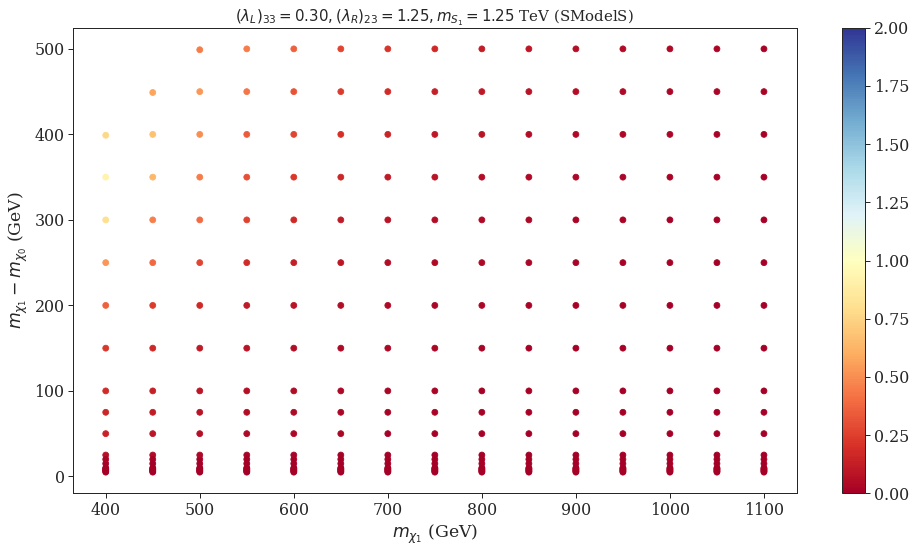

In [10]:
fig = plt.figure(figsize=(14,8))
cp = plt.scatter(rValues[:,0],rValues[:,1],c=rValues[:,2],s=35,cmap=plt.cm.get_cmap('RdYlBu'), vmin=0., vmax=2.)
# plt.plot(excCurve[:,0],excCurve[:,1],label='Exclusion',linewidth=3,linestyle='--')
# plt.fill_between(excCurve[:,0],excCurve[:,1],excCurve[:,1].max(),alpha=0.5)
# for ana,c in excCurveAnas.items():
#     plt.plot(c[:,0],c[:,1],label=ana,linewidth=3,linestyle='--')


cb = plt.colorbar(cp)
# plt.yscale('log')
plt.xlabel(r'$m_{\chi_1}$ (GeV)')    
plt.ylabel(r'$m_{\chi_1}-m_{\chi_0}$ (GeV)')
# plt.xlim(400.,1400.)
# plt.ylim(0,20.)
# plt.legend(loc=(1.2,0.6))
plt.title(r"$\left(\lambda_L\right)_{33} = %1.2f, \left(\lambda_R\right)_{23} = %1.2f, m_{S_1} = %1.2f$ TeV (SModelS)"
          %(lambdaL,lambdaR,mLQ/1000.0) ,fontsize=15)
plt.tight_layout()
# plt.savefig('T2bb_SModelSexclusion_BM2.png')
plt.show()

In [11]:
rValues[:,2].max()

0.9248277857560336